In [5]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import math
import open3d as o3d
# from open3d import JVisualizer
from enum import Enum
import cv2
import matplotlib.pyplot as plt
from scipy import ndimage
from skimage import feature
from scipy.stats import mode
import numpy as np

In [3]:
import numpy as np

def get_block(img, y, x, half_window_size):
	'''
	Parameters:
		img1- 3 channel (row, col, colors) numpy array representing a picture
		x and y- coordinates of center pixel or block
		half_window_size-- half the size of the desired block
	Returns:
		get_block -- gets the block of (half_window_size * 2 + 1) centered at y, x
	'''
	row_start = y - half_window_size
	row_end = y + half_window_size + 1

	col_start = x - half_window_size
	col_end = x + half_window_size + 1

	return np.array(img[row_start:row_end, col_start:col_end])

In [6]:
def median_filter_block(block):
	'''
	Parameters:
		block-- a block of an image
	Returns:
		a block of the same size where all pixels are filled with the same number (the most frequently appearing color)
	'''
	block[:,:] = mode(block, axis=None)[0]
	return block

def edge_aware_mode_filter(image, edges, mask_set, window_size):
	if(window_size==0 or np.all(mask_set == True)):
		return image;
	[h, w] = image.shape
	half_window_size = int(window_size/2)

	for y in range(half_window_size, h-half_window_size):
		for x in range(half_window_size, w-half_window_size):
	
			edge_block = get_block(edges, y, x, half_window_size)
			
			if(np.any(edge_block==1) or mask_set[y, x] == True):
				continue;

			img_block = get_block(image, y, x, half_window_size)
			image[y, x] = np.median(img_block)
			mask_set[y, x] = True

	return edge_aware_mode_filter(image, edges, mask_set, window_size - 1)

def filter_map(disparity_map, visible_disparity_map, left, window_size):
	'''
	Parameters:
		disparity_map-- disparity map to clean up 
		left-- left stereo image used to make the depth map
	Returns:
		a median filtered disparity map
	'''

	half_window_size = int(window_size/2)
	shape = left.shape
	h = shape[0]
	w = shape[1]

	edges_disparity = feature.canny(visible_disparity_map, sigma=3)
	edges_left = feature.canny(left, sigma=3)
	edges_left[edges_disparity==1] = 1
	
	filtered_map = edge_aware_mode_filter(disparity_map, edges_left, np.zeros(edges_left.shape), window_size)

	return filtered_map

In [9]:
def crop(img, window_size):
	'''
	Parameters:
		img-- numpy array representing a picture
		window_size-- window size used during depth map generation
	Returns:
		img cropped removing window_size/2 pixels from each side of the image
	'''
	shape = img.shape
	h = img.shape[0]
	w = img.shape[1]
	half_window_size = int(window_size/2)
	return img[half_window_size:h-half_window_size, half_window_size:w-half_window_size]

def sad(img1, img2):
	'''
	Parameters:
		img1-- numpy array representing a picture
		img2-- numpy array representing a picture
	Returns:
		float -- sum of absolute differences between img1 and shifted img2
	'''

	return np.sum(np.abs(np.subtract(img1, img2, dtype=np.float32)))

def distance_to_best_block(block1, block1_coordinates, img2, search_size, half_window_size):
	'''
	Parameters:
		block1-- 3 channel (row, col, colors) numpy array representing a block of a picture
		block1_coordinates-- tuple(r, w) or (y, x) representing location of center of block1 (used to calculate distance)
		img2-- 3 channel (row, col, colors) numpy array representing a picture
		search_size-- maximum number of pixels away we can look for matching blocks in img2
		half_window_size-- half size of possible blocks
	Returns:
		float distance between center of block1 and the best matching block within search_size

	iterate through all blocks of (2 * window_size + 1) in img2 no further than search_size away
	find the block with the minimum SAD (sum of absolute differences) to block 1 and retain its location coordinates
	return the distance between block 1 and the best block.
	'''
	[y, block1_x] = block1_coordinates
	
	best_sad = float('inf')
	best_x = block1_x

	for x in range(max(half_window_size, block1_x - search_size), min(img2.shape[1] - half_window_size, block1_x + search_size)):

		block2 = get_block(img2, y, x, half_window_size)

		curr_sad = sad(block1, block2)
		if(curr_sad < best_sad):
			best_sad=curr_sad
			best_x = x
			best_block = block2
	dist = abs(block1_x - best_x)

	return dist

def disparity_map(im_left, im_right, window_size, search_size):
	'''
	Parameters:
		im_left-- left stereo pair image file (numpy array)
		im_right-- right stereo pair image file (numpy array)
		window_size-- half size of possible blocks
		search_size-- maximum number of pixels away we can look for matching blocks in img2

	Returns:
		matrix containing displacement between xl and xr for a pixel (xl - xr)
	'''

	shape = im_left.shape

	h = shape[0]
	w = shape[1]
	
	disparity = np.zeros((h, w), 'uint8');
	half_window_size = int(window_size/2);

	print("creating disparity map...")
	for y in range(half_window_size, h-half_window_size):
		for x in range(half_window_size, w-half_window_size):
			block = get_block(im_left, y, x, half_window_size)
			distance = float(distance_to_best_block(block, (y, x), im_right, search_size, half_window_size))
			disparity[y, x] = distance
	print("created disparity map!")

	return crop(disparity, window_size = window_size)

def disparity_to_visible_disparity_map(disparity_matrix, search_size):
	'''
	Parameters:
		disparity_matrix-- matrix containing displacement between xl and xr for a pixel (xl - xr)
		search_size-- maximum pixels away travelled when searching for best matching block
	Returns:
		depth map in mm	
	'''
	disparity_matrix = disparity_matrix.astype(np.float64) / search_size
	disparity_matrix = 255 * disparity_matrix # Now scale by 255
	disparity_matrix = disparity_matrix.astype(np.uint8)
	return disparity_matrix


def disparity_to_depth_map(disparity_matrix, f, t, scale):
	'''
	Parameters:
		disparity_matrix-- matrix containing displacement between xl and xr for a pixel (xl - xr)
		f-- focal length in pixels
		t-- baseline in mm
		scale-- amount origional image was scaled down, used to scale down f and t
	Returns:
		depth map in mm	
	'''

	disparity_matrix = disparity_matrix.astype(np.float64)
	disparity_matrix = (f/scale) * (t/scale) / disparity_matrix
	disparity_matrix = disparity_matrix.astype(np.uint16)
	return disparity_matrix

def display_depth_map(depth_map, color_img, fx, fy, cx, cy, scale):
	'''
	Parameters:
		fx-- focal length in x dir (scaled if resized)
		fy-- focal length in y dir (scaled if resized)
		cx-- x axis principle point (scaled if resized)
		cy-- y axis principle point (scaled if resized)

	Displays an Open3D point cloud
	'''

	fx = fx/scale
	fy = fy/scale
	cx = cx/scale
	cy = cy/scale

	shape = color_img.shape;
	h = shape[0]
	w = shape[1]
	
	img = o3d.geometry.Image(color_img.astype('uint8'))
	depth = o3d.geometry.Image(depth_map.astype('uint16'))

	rgbd = o3d.geometry.RGBDImage.create_from_color_and_depth(img, depth)

	o3d_pinhole = o3d.camera.PinholeCameraIntrinsic()
	o3d_pinhole.set_intrinsics(w, h, fx, fy, cx, cy)

	pcd_from_depth_map = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd, o3d_pinhole)
	pcd_from_depth_map.transform([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]])
	o3d.visualization.draw_geometries([pcd_from_depth_map])

class ColorSpace(Enum):
	GREY = 1,
	BGR=2,
	R=3,
	G=4,
	B=5,
	LAB=6,
	L=7,
	YUV=8,
	Y=9,
	RGB=10

def get_data_in_color_space(file, color_space):
	'''
	Parameters:
		file-- file name of image to fetch pixel values for
		color_space-- ColorSpace enum type representing color space to return img as
	Returns:
		numpy array representing image converted into color space defined
	'''
	im_bgr = cv2.imread(file)
	im_lab = cv2.cvtColor(im_bgr, cv2.COLOR_BGR2LAB)
	im_yuv = cv2.cvtColor(im_bgr, cv2.COLOR_BGR2YUV)

	if(color_space == ColorSpace.GREY):
		print("fetching " + file + " in GREY")
		return cv2.cvtColor(im_bgr, cv2.COLOR_BGR2GRAY)
	elif(color_space == ColorSpace.R):
		print("fetching " + file + " in R")
		return im_bgr[:,:,2]
	elif(color_space == ColorSpace.G):
		print("fetching " + file + " in G")
		return im_bgr[:,:,1]
	elif(color_space == ColorSpace.B):
		print("fetching " + file + " in B")
		return im_bgr[:,:,0]
	elif(color_space == ColorSpace.LAB):
		print("fetching " + file + " in LAB")
		return im_lab
	elif(color_space == ColorSpace.L):
		print("fetching " + file + " in L")
		return im_lab[:,:,0]
	elif(color_space == ColorSpace.YUV):
		print("fetching " + file + " in YUV")
		return im_yuv
	elif(color_space == ColorSpace.Y):
		print("fetching " + file + " in Y")
		return im_yuv[:,:,0]
	elif(color_space == ColorSpace.RGB):
		print("fetching " + file + " in RGB")
		return cv2.cvtColor(im_bgr, cv2.COLOR_BGR2RGB)
	else:
		print("fetching " + file + " in BGR")
		return im_bgr

def average_disparity_maps(list_of_maps):
	disparity = np.zeros(list_of_maps[0].shape, 'uint8');
	print(disparity.shape)
	for i in range(list_of_maps[0].shape[0]):
		for j in range(list_of_maps[0].shape[1]):
			disparity_ij = []
			for disparity_matrix in list_of_maps:
				disparity_ij.append(disparity_matrix[i, j])
			disparity[i, j] = sum(disparity_ij)/len(disparity_ij)
	print(disparity)
	return disparity

fetching ./data/2006/bowling_L.png in YUV
fetching ./data/2006/bowling_R.png in YUV
creating disparity map...
created disparity map!


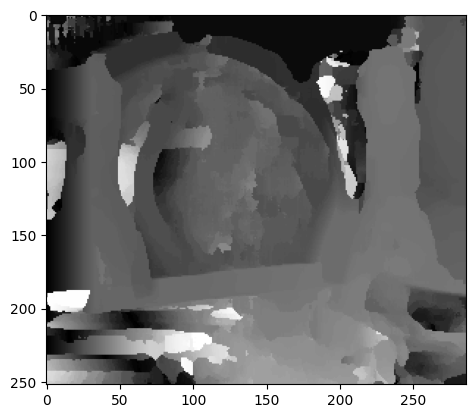

fetching ./data/2006/bowling_L.png in GREY
fetching ./data/2006/bowling_R.png in GREY
creating disparity map...
created disparity map!


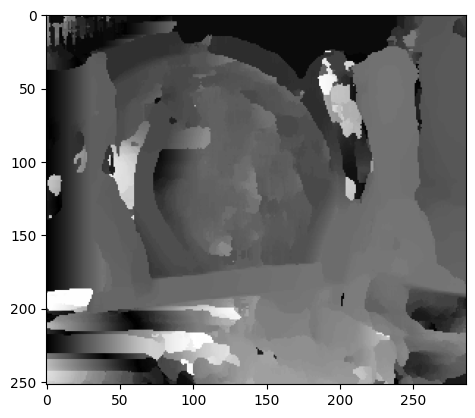

fetching ./data/2006/bowling_L.png in LAB
fetching ./data/2006/bowling_R.png in LAB
creating disparity map...
created disparity map!


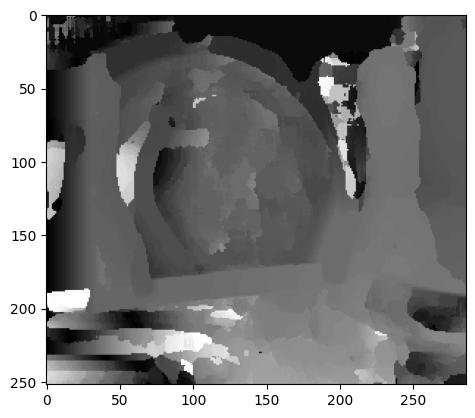

fetching ./data/2006/bowling_L.png in BGR
fetching ./data/2006/bowling_R.png in BGR
creating disparity map...
created disparity map!


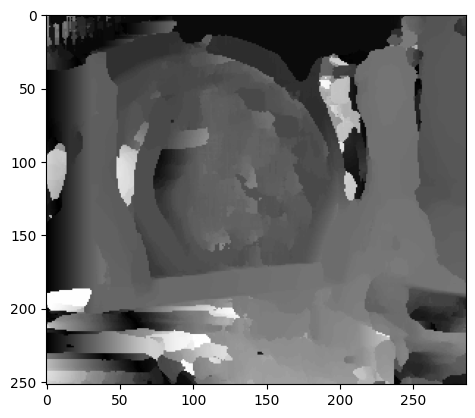

fetching ./data/2006/bowling_L.png in B
fetching ./data/2006/bowling_R.png in B
creating disparity map...
created disparity map!


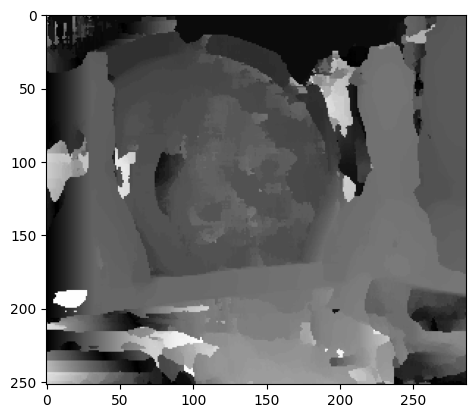

fetching ./data/2006/bowling_L.png in G
fetching ./data/2006/bowling_R.png in G
creating disparity map...
created disparity map!


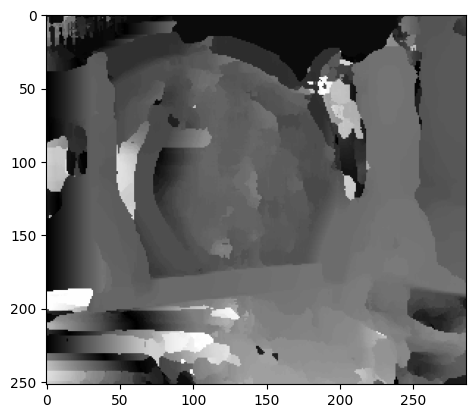

fetching ./data/2006/bowling_L.png in R
fetching ./data/2006/bowling_R.png in R
creating disparity map...
created disparity map!


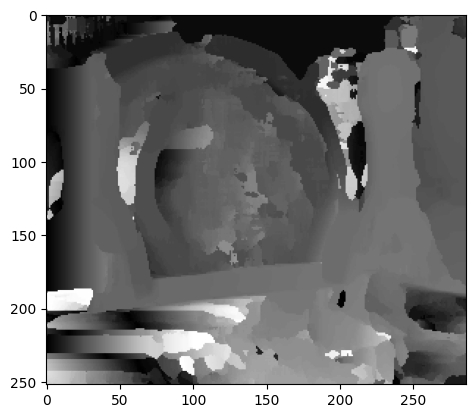

fetching ./data/2006/bowling_L.png in L
fetching ./data/2006/bowling_R.png in L
creating disparity map...
created disparity map!


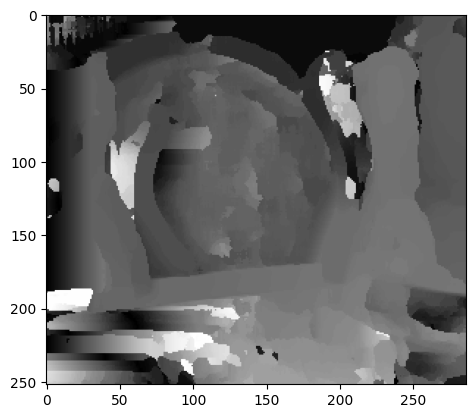

fetching ./data/2006/bowling_L.png in Y
fetching ./data/2006/bowling_R.png in Y
creating disparity map...
created disparity map!


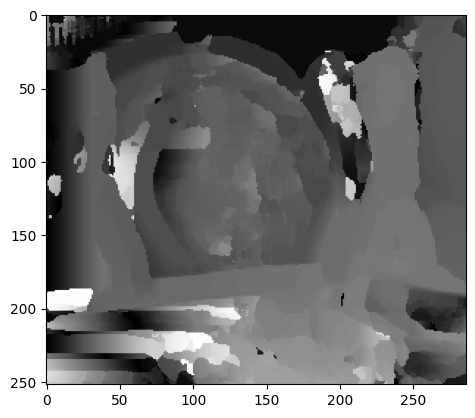

fetching ./data/2006/bowling_L.png in RGB
fetching ./data/2006/bowling_R.png in RGB
creating disparity map...
created disparity map!


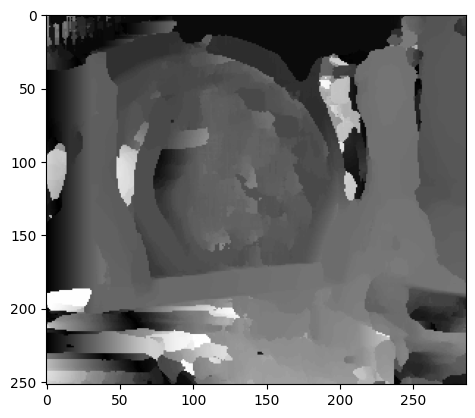

(252, 286)
[[38 25  9 ... 27 25 24]
 [38 39  6 ... 27 24 24]
 [31 30  8 ... 23 22 22]
 ...
 [74 74 74 ...  9  9 10]
 [72 71 71 ...  9  9  9]
 [72 71 70 ...  8  8  9]]
displaying average disparity map...


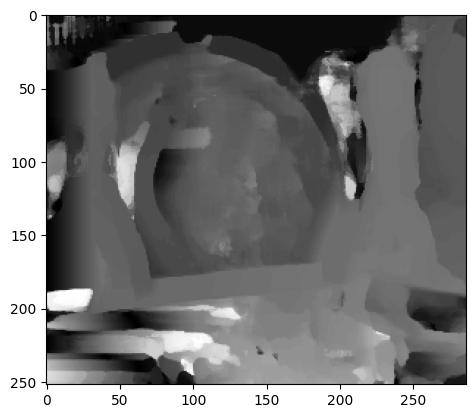

fetching ./data/2006/bowling_L.png in GREY
displaying filtered yuv disparity map...


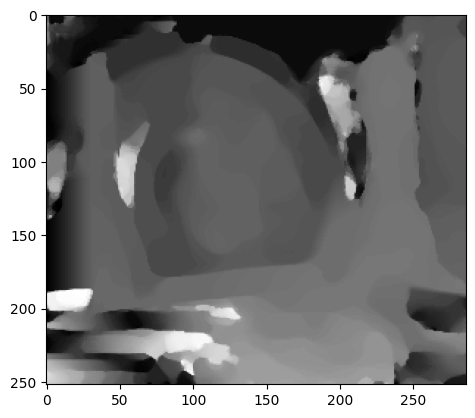

created depth map with range: 
61
65535
fetching ./data/2006/bowling_L.png in RGB
displaying depth map as point cloud!
[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display


/var/folders/06/9x6v8vd55lv98_m_jp45b7f80000gn/T/ipykernel_43395/432176004.py:115: RuntimeWarning: divide by zero encountered in divide
  disparity_matrix = (f/scale) * (t/scale) / disparity_matrix
/var/folders/06/9x6v8vd55lv98_m_jp45b7f80000gn/T/ipykernel_43395/432176004.py:116: RuntimeWarning: invalid value encountered in cast
  disparity_matrix = disparity_matrix.astype(np.uint16)


In [10]:
###### BELOW THIS POINT #####
#### code to actually call methods to create disparity maps ####

window_size = 15
search_size = 100

left = get_data_in_color_space('./data/2006/bowling_L.png', ColorSpace.YUV)
right = get_data_in_color_space('./data/2006/bowling_R.png', ColorSpace.YUV)

yuv_disparity_map = disparity_map(left, right, window_size, search_size)

plt.imshow(yuv_disparity_map, cmap='Greys_r')
plt.show()

left = get_data_in_color_space('./data/2006/bowling_L.png', ColorSpace.GREY)
right = get_data_in_color_space('./data/2006/bowling_R.png', ColorSpace.GREY)

grey_disparity_map = disparity_map(left, right, window_size, search_size)

plt.imshow(grey_disparity_map, cmap='Greys_r')
plt.show()

left = get_data_in_color_space('./data/2006/bowling_L.png', ColorSpace.LAB)
right = get_data_in_color_space('./data/2006/bowling_R.png', ColorSpace.LAB)

lab_disparity_map = disparity_map(left, right, window_size, search_size)

plt.imshow(lab_disparity_map, cmap='Greys_r')
plt.show()

left = get_data_in_color_space('./data/2006/bowling_L.png', ColorSpace.BGR)
right = get_data_in_color_space('./data/2006/bowling_R.png', ColorSpace.BGR)

bgr_disparity_map = disparity_map(left, right, window_size, search_size)

plt.imshow(bgr_disparity_map, cmap='Greys_r')
plt.show()

left = get_data_in_color_space('./data/2006/bowling_L.png', ColorSpace.B)
right = get_data_in_color_space('./data/2006/bowling_R.png', ColorSpace.B)

b_disparity_map = disparity_map(left, right, window_size, search_size)

plt.imshow(b_disparity_map, cmap='Greys_r')
plt.show()

left = get_data_in_color_space('./data/2006/bowling_L.png', ColorSpace.G)
right = get_data_in_color_space('./data/2006/bowling_R.png', ColorSpace.G)

g_disparity_map = disparity_map(left, right, window_size, search_size)

plt.imshow(g_disparity_map, cmap='Greys_r')
plt.show()

left = get_data_in_color_space('./data/2006/bowling_L.png', ColorSpace.R)
right = get_data_in_color_space('./data/2006/bowling_R.png', ColorSpace.R)

r_disparity_map = disparity_map(left, right, window_size, search_size)

plt.imshow(r_disparity_map, cmap='Greys_r')
plt.show()

left = get_data_in_color_space('./data/2006/bowling_L.png', ColorSpace.L)
right = get_data_in_color_space('./data/2006/bowling_R.png', ColorSpace.L)

l_disparity_map = disparity_map(left, right, window_size, search_size)

plt.imshow(l_disparity_map, cmap='Greys_r')
plt.show()

left = get_data_in_color_space('./data/2006/bowling_L.png', ColorSpace.Y)
right = get_data_in_color_space('./data/2006/bowling_R.png', ColorSpace.Y)

y_disparity_map = disparity_map(left, right, window_size, search_size)

plt.imshow(y_disparity_map, cmap='Greys_r')
plt.show()

left = get_data_in_color_space('./data/2006/bowling_L.png', ColorSpace.RGB)
right = get_data_in_color_space('./data/2006/bowling_R.png', ColorSpace.RGB)

rgb_disparity_map = disparity_map(left, right, window_size, search_size)

plt.imshow(rgb_disparity_map, cmap='Greys_r')
plt.show()

final_disparity_map = average_disparity_maps([yuv_disparity_map, grey_disparity_map, lab_disparity_map, bgr_disparity_map, b_disparity_map, g_disparity_map, r_disparity_map, l_disparity_map, y_disparity_map, rgb_disparity_map])

visible_disparity_map = disparity_to_visible_disparity_map(final_disparity_map, search_size)

print("displaying average disparity map...")
plt.imshow(visible_disparity_map, cmap='Greys_r')
plt.show()

left_gray = crop(get_data_in_color_space('./data/2006/bowling_L.png', ColorSpace.GREY), window_size = window_size)

filtered_disparity_map = filter_map(final_disparity_map, visible_disparity_map, left_gray, window_size);
visible_filtered_disparity_map = disparity_to_visible_disparity_map(filtered_disparity_map, search_size)

print("displaying filtered yuv disparity map...")
plt.imshow(visible_filtered_disparity_map, cmap='Greys_r')
plt.show()

depth_map = disparity_to_depth_map(filtered_disparity_map, f=3740, t=160, scale=9.88)
print("created depth map with range: ")
print(np.min(depth_map, axis=None))
print(np.max(depth_map, axis=None))

left_rgb = crop(get_data_in_color_space('./data/2006/bowling_L.png', ColorSpace.RGB), window_size = window_size)

print("displaying depth map as point cloud!")
display_depth_map(depth_map, left_rgb, fx = 5814.40964, fy = 5814.40964, cx = 1176.72776, cy = 1176.72776, scale = 9.88)